# Finetuning model for Event summarisation

In [1]:
import json
import torch
import random
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from bert_score import score
import evaluate
import os
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize

# Make sure the required NLTK data packages are available
# Dynamically construct NLTK data directory relative to current working directory
nltk_data_dir = os.path.join(os.getcwd(), "venv", "nltk_data")

# Create directory if it doesn't exist
os.makedirs(nltk_data_dir, exist_ok=True)

nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_dir)
nltk.download("stopwords", download_dir=nltk_data_dir)

[nltk_data] Downloading package punkt to d:\Keven(Work)\dsa4213\final
[nltk_data]     project\venv\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     d:\Keven(Work)\dsa4213\final project\venv\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     d:\Keven(Work)\dsa4213\final project\venv\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# set seed for reproducibility
def set_seed(seed=4213):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(4213)

In [3]:
# Config
# ==============================
TRAIN_FILE = "stories_with_outlines_first3000.jsonl"
OUTPUT_DIR = "./Event-summariser-LoRA-v3"
BASE_MODEL = "t5-small"
BASE_MODEL2 = "google/flan-t5-base"
USE_LORA = True
MAX_INPUT_LENGTH = 256
MAX_TARGET_LENGTH = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data preprocessing

In [4]:
# Read in raw data

print(f"Loading each event dataset: {TRAIN_FILE}")
# Read all lines as JSON
raw_data = []
with open(TRAIN_FILE, "r", encoding="utf-8") as f:
    for line in f:
        each_line = json.loads(line)
        # extract story text and reformat into a list of lines
        story = each_line['story']
        lines_of_story = sent_tokenize(story)
        # extract outline details: events
        outline = each_line['outline']
        events = outline.get('events', [])
        full_summary = ""
        for key, value in events.items():
            event_summary = value.get('summary')
            # Now we want to slice the stories based on 'from_lines'
            from_lines = value.get('from_lines', [])
            start_idx = from_lines[0] - 1  # Convert to 0-based index
            end_idx = from_lines[-1]  # Inclusive end index
            event_text = " ".join(lines_of_story[start_idx:end_idx])
            # For each event_text, prepend the prompt
            prompt = "Summarize this text:\n" 
            final_input = prompt + event_text #+ "\nSummary:"

            # append to dataset
            raw_data.append({"instruction": final_input, "response": event_summary})

raw_data[:10]  # preview first 10 entries 

Loading each event dataset: stories_with_outlines_first3000.jsonl


[{'instruction': 'Summarize this text:\nOnce upon a time, in a warm and sunny place, there was a big pit. A little boy named Tom liked to play near the pit.',
  'response': 'Tom enjoys playing near a big pit in a sunny location.'},
 {'instruction': 'Summarize this text:\nOne day, Tom lost his red ball. He was very sad.',
  'response': 'Tom loses his red ball and feels very sad about it.'},
 {'instruction': 'Summarize this text:\nTom asked his friend, Sam, to help him search for the ball. They looked high and low, but they could not find the ball.',
  'response': 'Tom asks his friend Sam for help, and they search for the ball without success.'},
 {'instruction': 'Summarize this text:\nTom said, "I think my ball fell into the pit." Sam and Tom went close to the pit. They were scared, but they wanted to find the red ball.',
  'response': 'Tom suspects the ball fell into the pit, and he and Sam approach it despite their fear.'},
 {'instruction': 'Summarize this text:\nThey looked into the 

In [5]:
dataset = Dataset.from_list(raw_data)
dataset = dataset.train_test_split(test_size=0.01)
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'response'],
        num_rows: 16592
    })
    test: Dataset({
        features: ['instruction', 'response'],
        num_rows: 168
    })
})

In [6]:
# Prepare tokenizer and model
print(f"Loading base model: {BASE_MODEL}")
base_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

Loading base model: t5-small


In [7]:
# Preprocessing function
def preprocess_function(batch):
    model_inputs = tokenizer(
        batch["instruction"],
        max_length=MAX_INPUT_LENGTH,
        padding="max_length",
        truncation=True,
    )
    labels = tokenizer(
        text_target=batch["response"],
        max_length=MAX_TARGET_LENGTH,
        padding="max_length",
        truncation=True,
        )  
    # Replace pad token IDs with -100 so they’re ignored in cross-entropy loss
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize the dataset
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["instruction", "response"],
    desc="Tokenizing dataset",
)

Tokenizing dataset: 100%|██████████| 168/168 [00:00<00:00, 1435.91 examples/s]


In [8]:
# Test current model with zero shot inference
from torch import no_grad

# use one example from test set
event = dataset['test'][67]["instruction"]
summary = dataset['test'][67]["response"]

# Tokenise input
inputs = tokenizer(event, return_tensors="pt", max_length=MAX_INPUT_LENGTH, truncation=True).to(DEVICE)
# Generate output and decode
with no_grad():
    outputs = base_model.generate(
        **inputs,
        max_new_tokens=MAX_TARGET_LENGTH,
        num_beams=4,
        early_stopping=True
    )
base_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

dashline = "-" * 80
print(dashline)
print("Event:")
print(event)
print(dashline)
print("Expected summary:")  
print(summary)
print(dashline)
print("Model Output summary:")
print(base_output)
print(dashline)

--------------------------------------------------------------------------------
Event:
Summarize this text:
Once upon a time, in a big town, there was a lot of traffic. Cars, buses, and bikes went up and down the roads all day. People were always in a hurry, and they did not look around. They were ignorant of the nice things around them.
--------------------------------------------------------------------------------
Expected summary:
In a bustling town filled with traffic, people hurriedly moved about, often ignoring their surroundings.
--------------------------------------------------------------------------------
Model Output summary:
False
--------------------------------------------------------------------------------


# PEFT model using LoRA
(skip the cells in this section if not finetuning)

In [25]:
# LoRA configuration
if USE_LORA:
    print("Applying LoRA adapter for lightweight fine-tuning...")
    lora_config = LoraConfig(
        r=8,
        lora_alpha=32,
        target_modules=["q", "v"],
        lora_dropout=0.05,
        bias="none",
        task_type="SEQ_2_SEQ_LM",
    )
lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()

print(f"Using device: {DEVICE}")
lora_model = lora_model.to(DEVICE)

# PEFT Training configuration
peft_training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    auto_find_batch_size=True,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=3e-5,
    fp16=torch.cuda.is_available(),
    predict_with_generate=True,
    report_to="none",  # disable wandb/tensorboard
    save_strategy="steps",  
    save_steps=50,          
    save_total_limit=3,     
    logging_strategy="epoch",
)

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=lora_model
)

# PEFT Trainer setup
peft_trainer = Trainer(  
    model=lora_model,
    args=peft_training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    processing_class=tokenizer,
)

Applying LoRA adapter for lightweight fine-tuning...
trainable params: 294,912 || all params: 60,801,536 || trainable%: 0.4850
Using device: cuda


In [26]:
# Initiate training

print("Starting training...")
# Resume only if checkpoint exists
resume_checkpoint = None
last_checkpoint_dir = os.path.join(OUTPUT_DIR, "checkpoint-last")
if os.path.isdir(last_checkpoint_dir):
    resume_checkpoint = last_checkpoint_dir
    print(f"Resuming from checkpoint: {resume_checkpoint}")
else:
    print("No existing checkpoint found — starting fresh training.")

# Else start training
peft_trainer.train(resume_from_checkpoint=resume_checkpoint)

# Save the final model with training logs
print(f"Saving LoRA fine-tuned model to {OUTPUT_DIR}")
lora_model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
peft_trainer.save_state()

Starting training...
No existing checkpoint found — starting fresh training.


Step,Training Loss
519,2.723300
1038,2.382100
1557,2.317900


Saving LoRA fine-tuned model to ./Event-summariser-LoRA-v2


# Models Testing and Comparison

In [9]:
# Now we can test and compare the models on the same example
def load_model_for_inference(directory, device=DEVICE):
    if directory==BASE_MODEL or BASE_MODEL2:
        model = AutoModelForSeq2SeqLM.from_pretrained(directory)
        tokenizer = AutoTokenizer.from_pretrained(directory)
    else:
        config = PeftConfig.from_pretrained(directory)
        base_model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)
        model = PeftModel.from_pretrained(base_model, directory)
        tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
    model = model.to(device)
    model.eval()  # ensure inference mode
    print(f"Loaded {directory} on device: {device}")
    return model, tokenizer

# function to generate outputs
def generate_output(text_input, model, tokenizer, device=DEVICE):
    # generate input
    inputs = tokenizer(text_input, return_tensors="pt").to(device)
    # then generate output
    with torch.inference_mode():
        output = tokenizer.decode(
        model.generate(**inputs, max_new_tokens=MAX_TARGET_LENGTH)[0],
        skip_special_tokens=True
    )
    return output

t5_small, t5s_tokenizer = load_model_for_inference(BASE_MODEL)
flan_t5, ft5_tokenizer = load_model_for_inference(BASE_MODEL2)
lora_v1, lv1_tokenizer = load_model_for_inference("./Event-summariser-LoRA-v1")
lora_v2, lv2_tokenizer = load_model_for_inference("./Event-summariser-LoRA-v2")
lora_v3, lv3_tokenizer = load_model_for_inference("./Event-summariser-LoRA-v3")

Loaded t5-small on device: cuda
Loaded google/flan-t5-base on device: cuda
Loaded ./Event-summariser-LoRA-v1 on device: cuda
Loaded ./Event-summariser-LoRA-v2 on device: cuda
Loaded ./Event-summariser-LoRA-v3 on device: cuda


In [10]:
# Display summaries
print("-" * 100)
print("Actual Text:")
print(event)
print("-" * 100)
print("Expected summary:")  
print(summary)
print("-" * 100)
print("t5_small Output summary:")
print(generate_output(event, t5_small, t5s_tokenizer))
print("-" * 100)
print("flan_t5 Output summary:")
print(generate_output(event, flan_t5, ft5_tokenizer))
print("-" * 100)
print("lora_v1 Output summary:")
print(generate_output(event, lora_v1, lv1_tokenizer))
print("-" * 100)
print("lora_v2 Output summary:")
print(generate_output(event, lora_v2, lv2_tokenizer))
print("-" * 100)
print("lora_v3 Output summary:")
print(generate_output(event, lora_v3, lv3_tokenizer))
print("-" * 100)


----------------------------------------------------------------------------------------------------
Actual Text:
Summarize this text:
Once upon a time, in a big town, there was a lot of traffic. Cars, buses, and bikes went up and down the roads all day. People were always in a hurry, and they did not look around. They were ignorant of the nice things around them.
----------------------------------------------------------------------------------------------------
Expected summary:
In a bustling town filled with traffic, people hurriedly moved about, often ignoring their surroundings.
----------------------------------------------------------------------------------------------------
t5_small Output summary:
True
----------------------------------------------------------------------------------------------------
flan_t5 Output summary:
The traffic was very bad.
----------------------------------------------------------------------------------------------------
lora_v1 Output summary:
In

# Evaluation using ROGUE + BERT scores

In [11]:
# prepare the eval dataset to be used for rouge evaluation
original_summaries = []
base_model1_predictions = []
base_model2_predictions = []
lora1_model_predictions = []
lora2_model_predictions = []
lora3_model_predictions = []

print("Generating predictions...")
for item in dataset['test']:    # replace test_subset with eval_data
    # original summary list
    original_summaries.append(item["response"])
    # predictions
    base1_output = generate_output(item["instruction"], t5_small, t5s_tokenizer)
    base_model1_predictions.append(base1_output)
    base2_output = generate_output(item["instruction"], flan_t5, ft5_tokenizer)
    base_model2_predictions.append(base2_output)
    lora1_output = generate_output(item["instruction"], lora_v1, lv1_tokenizer)
    lora1_model_predictions.append(lora1_output)
    lora2_output = generate_output(item["instruction"], lora_v2, lv2_tokenizer)
    lora2_model_predictions.append(lora2_output)
    lora3_output = generate_output(item["instruction"], lora_v3, lv3_tokenizer)
    lora3_model_predictions.append(lora3_output)



Generating predictions...


In [12]:
# combine into dataframe
df = pd.DataFrame({
    "Original Summary": original_summaries,
    "t5-small Prediction": base_model1_predictions,
    "flan-t5-base Prediction": base_model2_predictions,
    "LoRA-v1 Model Prediction": lora1_model_predictions,
    "LoRA-v2 Model Prediction": lora2_model_predictions,
    "LoRA-v3 Model Prediction": lora3_model_predictions
})

df.head(5)

,Original Summary,t5-small Prediction,flan-t5-base Prediction,LoRA-v1 Model Prediction,LoRA-v2 Model Prediction,LoRA-v3 Model Prediction
0,"One friend suggests using sign language, which...",Zusammenfassen text: One of her friends sugges...,Molly was excited to try to sign to another fr...,One of her friends suggested they sign to each...,"Molly, a friend of Molly, is confused but exci...",Molly was excited to try to sign to another fr...
1,"After waiting for a while, the toy egg does no...",Zusammenfassen Sie diesen Text: Lucy hat sehr ...,Lucy was excited to see her friends.,Lucy is excited about the success of the proje...,Lucy and Lucy are excited about the success of...,Lucy was excited to see her friends.
2,"Lily, a little girl, wakes up in her comfortab...",Text: Let's resume this text:,Look at the bed.,"Lily, a little girl, had a big, soft, comforta...","Lily, a little girl, wakes up and changes her ...",Look at the bed.
3,They read about the aeroplane's engine and fun...,Zusammenfassend,They went to the library to read a book about ...,The two friends discover the aeroplane from th...,The two friends decided to find out more about...,They went to the library to read a book about ...
4,"Despite his mom's warnings, Tom runs around ca...",False,Tom was scared of bees.,Tom did not listen to his mom when she told hi...,"Tom does not look where he is going, but does ...",Tom was scared of bees.


In [19]:
# Perform ROUGE evaluation
def compute_rouge_score(predictions, references):
    rouge = evaluate.load("rouge")
    results = rouge.compute(
        predictions=predictions, 
        references=references,
        use_aggregator=True,
        use_stemmer=True,
    )
    return results

# Clean text for fair comparison
original_summaries = [s.strip().lower() for s in original_summaries]
base_model1_predictions = [p.strip().lower() for p in base_model1_predictions]
base_model2_predictions = [p.strip().lower() for p in base_model2_predictions]
lora_model1_predictions = [p.strip().lower() for p in lora1_model_predictions]
lora_model2_predictions = [p.strip().lower() for p in lora2_model_predictions]
lora_model3_predictions = [p.strip().lower() for p in lora3_model_predictions]

# Compute ROUGE scores
base_model1_results = compute_rouge_score(base_model1_predictions, original_summaries)
base_model2_results = compute_rouge_score(base_model2_predictions, original_summaries)
lora1_model_results = compute_rouge_score(lora1_model_predictions, original_summaries)
lora2_model_results = compute_rouge_score(lora2_model_predictions, original_summaries)
lora3_model_results = compute_rouge_score(lora3_model_predictions, original_summaries)

all_results = {
    "t5-small Model": base_model1_results,
    "flan-t5-base Model": base_model2_results,
    "LoRA-v1 Model": lora1_model_results,
    "LoRA-v2 Model": lora2_model_results,
    "LoRA-v3 Model": lora3_model_results
}


# Compare relative percentage differences in rouge scores over base model
def display_percentage_difference(base_results, new_results, model_name):
    print(f"Relative Percentage Differences in ROUGE scores for {model_name} over Base Model:")
    for key in base_results.keys():
        base_score = base_results[key] * 100  # convert to percentage
        new_score = new_results[key] * 100  # convert to percentage
        relative_diff = ((new_score - base_score) / base_score) * 100
        print(f"{key}: {relative_diff:.2f}%")
    print(dashline)

#display_percentage_difference(base_model_results, lora1_model_results, "LoRA-v1 Model")
#display_percentage_difference(base_model_results, lora2_model_results, "LoRA-v2 Model")

In [20]:
print("ROUGE scores for various models against ground truth summaries:")
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df.head()

ROUGE scores for various models against ground truth summaries:


,rouge1,rouge2,rougeL,rougeLsum
t5-small Model,0.151451,0.066716,0.128294,0.128367
flan-t5-base Model,0.251915,0.066191,0.216323,0.216722
LoRA-v1 Model,0.476206,0.247403,0.411782,0.411357
LoRA-v2 Model,0.447332,0.218330,0.391013,0.392638
LoRA-v3 Model,0.251915,0.066191,0.216323,0.216722


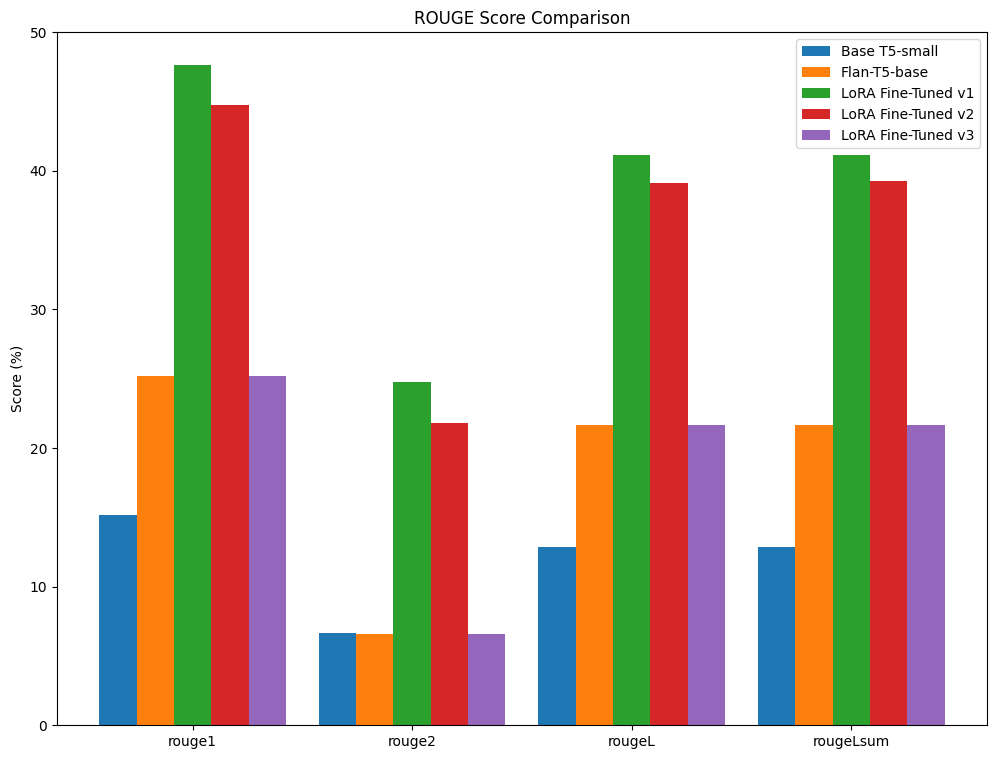

In [24]:
# Plot visuals
keys = list(base_model1_results.keys())
base1_vals = [base_model1_results[k] * 100 for k in keys]
base2_vals = [base_model2_results[k] * 100 for k in keys]
lora1_vals = [lora1_model_results[k] * 100 for k in keys]
lora2_vals = [lora2_model_results[k] * 100 for k in keys]
lora3_vals = [lora3_model_results[k] * 100 for k in keys]

x = np.arange(len(keys))  # the label locations
width = 0.17             # width of each bar

plt.figure(figsize=(12, 9))
plt.bar(x - width*2, base1_vals, width, label='Base T5-small')
plt.bar(x - width, base2_vals, width, label='Flan-T5-base')
plt.bar(x , lora1_vals, width, label='LoRA Fine-Tuned v1')
plt.bar(x + width, lora2_vals, width, label='LoRA Fine-Tuned v2')
plt.bar(x + width*2, lora3_vals, width, label='LoRA Fine-Tuned v3')

plt.xticks(x, keys)
plt.title('ROUGE Score Comparison')
plt.ylabel('Score (%)')
plt.legend()
plt.show()

In [13]:
# Now evaluate using BERT score
def compute_bert_score(predictions, references):
    P, R, F1 = score(predictions, references, model_type="roberta-large" ,lang="en", verbose=True)
    return {
        "precision": P.mean().item(),
        "recall": R.mean().item(),
        "f1": F1.mean().item()
    }

base_model1_bert = compute_bert_score(base_model1_predictions, original_summaries)
base_model2_bert = compute_bert_score(base_model2_predictions, original_summaries)
lora1_model_bert = compute_bert_score(lora1_model_predictions, original_summaries)
lora2_model_bert = compute_bert_score(lora2_model_predictions, original_summaries)
lora3_model_bert = compute_bert_score(lora3_model_predictions, original_summaries)

all_berts = {
    "t5-small Model": base_model1_bert,
    "flan-t5-base Model": base_model2_bert,
    "LoRA-v1 Model": lora1_model_bert,
    "LoRA-v2 Model": lora2_model_bert,
    "LoRA-v3 Model": lora3_model_bert
}

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 5/5 [00:35<00:00,  7.16s/it]


computing greedy matching.


100%|██████████| 3/3 [00:00<00:00, 17.14it/s]


done in 36.06 seconds, 4.66 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 6/6 [00:18<00:00,  3.02s/it]


computing greedy matching.


100%|██████████| 3/3 [00:00<00:00, 35.39it/s]


done in 18.26 seconds, 9.20 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 6/6 [00:20<00:00,  3.38s/it]


computing greedy matching.


100%|██████████| 3/3 [00:00<00:00, 56.59it/s]


done in 20.35 seconds, 8.26 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 6/6 [00:19<00:00,  3.33s/it]


computing greedy matching.


100%|██████████| 3/3 [00:00<00:00, 56.61it/s]


done in 20.04 seconds, 8.38 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


computing greedy matching.


100%|██████████| 3/3 [00:00<00:00, 56.60it/s]

done in 16.55 seconds, 10.15 sentences/sec


In [14]:
print("BERT scores for predictions against actual summaries:")
bert_df = pd.DataFrame.from_dict(all_berts, orient='index')
bert_df.head()

BERT scores for predictions against actual summaries:


,precision,recall,f1
t5-small Model,0.830578,0.851901,0.839987
flan-t5-base Model,0.906498,0.869756,0.887633
LoRA-v1 Model,0.918053,0.916870,0.917388
LoRA-v2 Model,0.916540,0.907566,0.911930
LoRA-v3 Model,0.906498,0.869756,0.887633
